In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

from vatools.utils import data_processing as db
from vatools.db_conn.db_conn import DBConnection
from vatools.ml import ml

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)


/usr/local/lib/python3.6/dist-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/

In [5]:
db = DBConnection('../credentials.json')
db.connect()

In [4]:
db.close()

## Exploring the Data

In [6]:
outcomes = db.query('select * from outcomes;')
projects = db.query('select * from projects;')

The data profiles of the data below help identify missing values and see value distributions across variables. Points of main interest are:
- Note the columns with missing values, such as the 116,086 consistently missing values in secondary focus areas and subjects, and the 43,021 missing values in school_metro, which indicates whether a school is in an urban, rural, or suburban region. 


- Also worthy of noting is the heavy right skew of both total price including and excluding optional support. 


- Lastly, it is important to note that high cardinality variables like county, city, state, etc. should be reduced in categories or ommitted from model training.

In [6]:
db.profile('projects')

Number of variables,35
Number of observations,353151
Total Missing (%),2.2%
Total size in memory,94.3 MiB
Average record size in memory,280.0 B
Numeric,5
Categorical,29
Boolean,0
Date,0
Text (Unique),1
Rejected,0


# Preprocessing

In [8]:
outcomes.head()

,projectid,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,fffe0bb8af3b9cd93046b49653cc923a,t,t,t,t,t,t,t,f,100.0,1.0,5.0
1,fffdf9d286e715165b60674ac9d05c6c,f,f,t,t,t,t,t,f,66.0,0.0,5.0
2,fffb88aa251449f1ba0b31d5552426b0,f,f,t,t,t,t,t,f,66.0,0.0,13.0
3,fffb183a77300b3756b8c1dba0b6350f,f,f,t,f,f,f,t,f,0.0,0.0,1.0
4,fffaaa855c693496ffd4778ae1ce5985,f,f,t,f,f,f,t,f,0.0,0.0,1.0


## Outcomes Preprocessing Notes


fully_funded - fix bool  


## Projects Preprocess Notes

Initial notes below, further preprocessing to be done this weekend.  

projectid - None  
teacher_acctid - None  
schoolid - None  
school_ncesid - None  
school_latitude - None  
school_longitude - None  
school_city - None  
school_state - None  
school_zip - None  
school_metro - None  
school_district -   
school_county - reduce cardinality 
school_charter - fix bool  
school_magnet - fix bool  
school_year_round - fix bool  
school_nlns -  
school_kipp - fix bool  
school_charter_ready_promise - fix bool  
teacher_prefix -  
teacher_teach_for_america - fix bool  
teacher_ny_teaching_fellow - fix bool  
primary_focus_subject - None   
primary_focus_area - map to fewer categories  
secondary_focus_subject - None   
secondary_focus_area - map to fewer categories  
resource_type - dummies   
poverty_level - dummies 
grade_level - dummies 
fulfillment_labor_materials - None  
total_price_excluding_optional_support - discretize  
total_price_including_optional_support - discretize  
students_reached - discretize  
eligible_double_your_impact_match - fix bool  
eligible_almost_home_match - fix bool  
date_posted - None  

In [7]:
run ../preprocess

Missing values in projects data imputed. See preprocess.py for details.

Booleans in Outcomes set to 1 and 0.

Booleans in Projects set to 1 and 0 from t/f.

students_reached 5
[-1.1142e+01  2.4294e+03  4.8578e+03  7.2862e+03  9.7146e+03  1.2143e+04]
1    351977
4         2
3         2
5         1
2         1
Name: students_reached, dtype: int64
total_price_excluding_optional_support 5
[-1.02658380e+02  2.79747060e+04  5.59123820e+04  8.38500580e+04
  1.11787734e+05  1.39725410e+05]
1    352045
2        29
3         6
5         2
4         2
Name: total_price_excluding_optional_support, dtype: int64
total_price_including_optional_support 6
[-1.2077928e+02  2.7433440e+04  5.4823320e+04  8.2213200e+04
  1.0960308e+05  1.3699296e+05  1.6438284e+05]
1    352031
2        37
3        11
6         2
4         2
5         1
Name: total_price_including_optional_support, dtype: int64
Columns in projects successfully discretized.

Dummies created!

High cardinality columns fixed!

CREATE TABLE ou

ProgrammingError: relation "combined_data" already exists


## Exploring Feature Interactions with Outcome Variable

In [51]:
db.close()
db.connect()

In [52]:
db.query('''CREATE TABLE combined_data as 
                SELECT a.*,
                       b.not_fully_funded
                FROM projects_cleaned a 
                JOIN outcomes_cleaned b 
                ON a.projectid = b.projectid
                WHERE extract(isoyear from date_posted) in (2011, 2012, 2013);''', False)

In [8]:
db.connect()
combined_data = db.query('select * from combined_data')

In [9]:
combined_data['year'] = combined_data['date_posted'].apply(lambda x: x.year)

year,2011,2012,2013
row_0,,,
total,103626,117626,130832


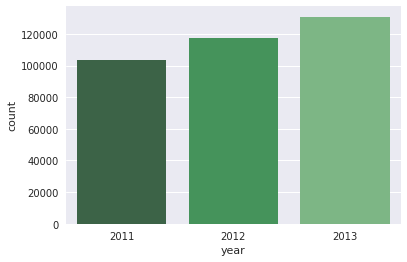

In [10]:
sns.countplot(x="year", data=combined_data,palette="Greens_d")
pd.crosstab('total',combined_data['year'],)

### Count of Projects Not Funded Across Years

year,2011,2012,2013
not_fully_funded,,,
0,70353,84550,92045
1,33273,33076,38787


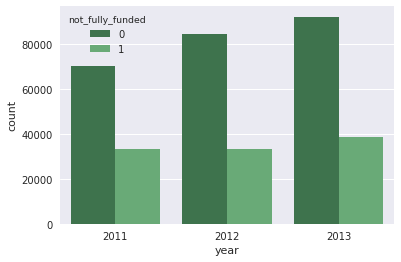

In [57]:
sns.countplot(x="year", data=combined_data, hue='not_fully_funded',palette="Greens_d")
pd.crosstab(combined_data['not_fully_funded'],combined_data['year'])

**NOTE:** Since there is an overrepresentation of projects that **were** fully funded, we will understample the fully funded projects to get a more balanced set of examples to train on.

not_fully_funded,0,1
row_0,,
Total,246948,105136


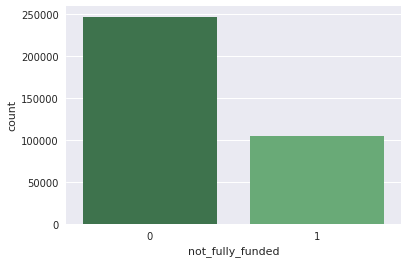

In [58]:
sns.countplot(x="not_fully_funded", data=combined_data, palette="Greens_d")
pd.crosstab('Total',combined_data['not_fully_funded'])

### Creating Balanced Dataset

In [11]:
under_sample = combined_data[combined_data['not_fully_funded']==0].sample(120000)
balanced_dataset = combined_data[combined_data['not_fully_funded']==1].append(under_sample)

not_fully_funded,0,1
row_0,,
Total,120000,105136


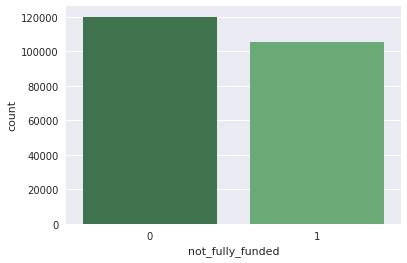

In [12]:
sns.countplot(x="not_fully_funded", data=balanced_dataset, palette="Greens_d")
pd.crosstab('Total',balanced_dataset['not_fully_funded'])

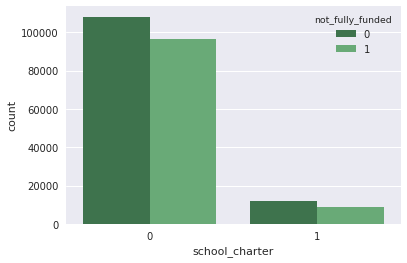

In [61]:
sns.countplot(x="school_charter", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

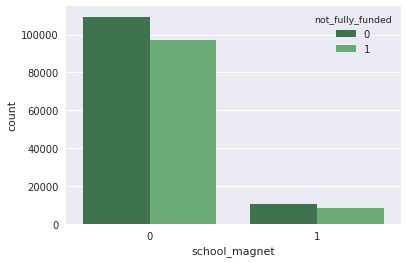

In [62]:
sns.countplot(x="school_magnet", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

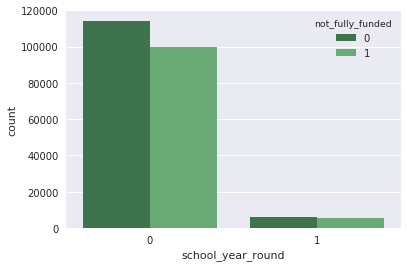

In [63]:
sns.countplot(x="school_year_round", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

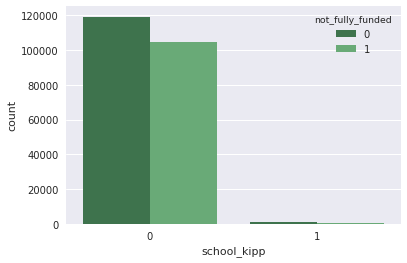

In [64]:
sns.countplot(x="school_kipp", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

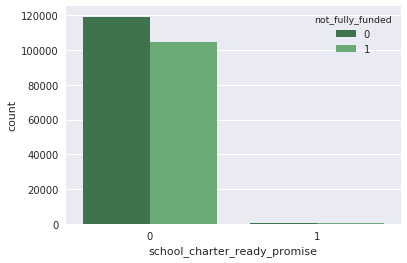

In [65]:
sns.countplot(x="school_charter_ready_promise", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

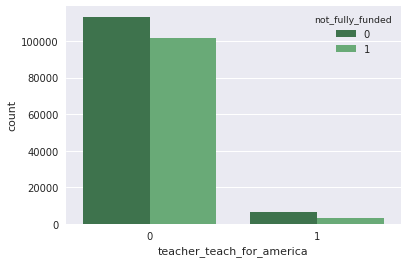

In [66]:
sns.countplot(x="teacher_teach_for_america", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

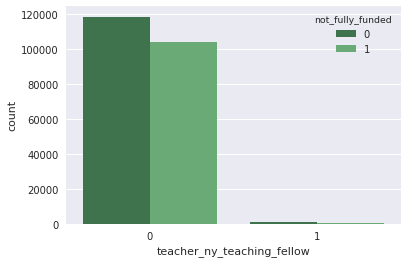

In [67]:
sns.countplot(x="teacher_ny_teaching_fellow", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

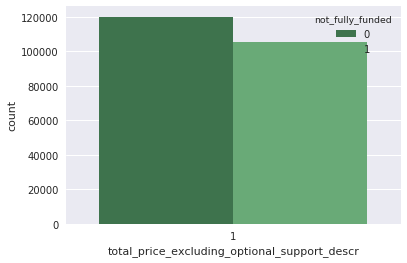

In [68]:
sns.countplot(x="total_price_excluding_optional_support_descr", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

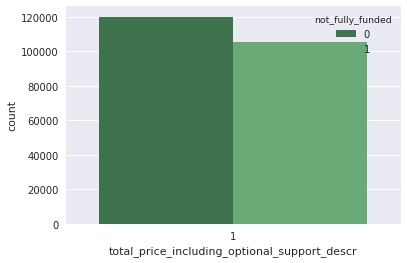

In [69]:
sns.countplot(x="total_price_including_optional_support_descr", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

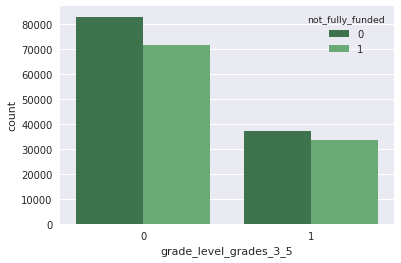

In [70]:
sns.countplot(x="grade_level_grades_3_5", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

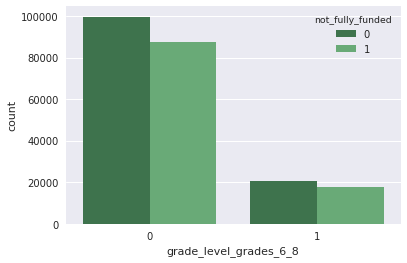

In [71]:
sns.countplot(x="grade_level_grades_6_8", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

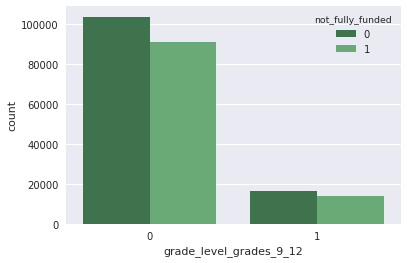

In [72]:
sns.countplot(x="grade_level_grades_9_12", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

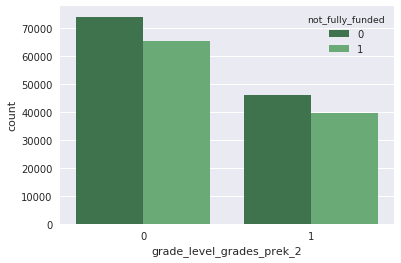

In [73]:
sns.countplot(x="grade_level_grades_prek_2", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

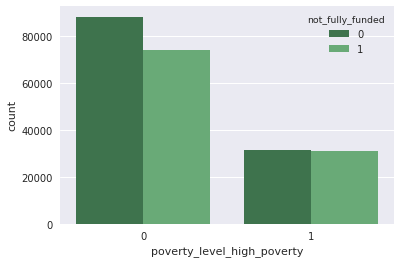

In [74]:
sns.countplot(x="poverty_level_high_poverty", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

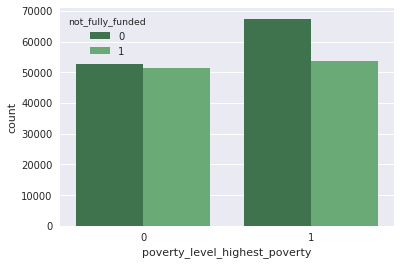

In [75]:
sns.countplot(x="poverty_level_highest_poverty", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

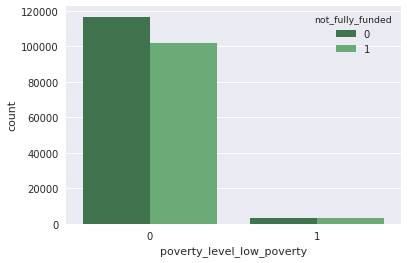

In [76]:
sns.countplot(x="poverty_level_low_poverty", 
              data=balanced_dataset, 
              hue= 'not_fully_funded', 
              palette="Greens_d")

## Feature Sets

In [13]:
all_features = [
'school_charter',
'school_magnet',
'school_year_round',
'school_kipp',
'school_charter_ready_promise',
'teacher_teach_for_america',
'teacher_ny_teaching_fellow',
'eligible_double_your_impact_match',
'eligible_almost_home_match',
'total_price_excluding_optional_support_descr',
'total_price_including_optional_support_descr',
'grade_level_grades_3_5',
'grade_level_grades_6_8',
'grade_level_grades_9_12',
'grade_level_grades_prek_2',
'grade_level_missing',
'poverty_level_high_poverty',
'poverty_level_highest_poverty',
'poverty_level_low_poverty',
'poverty_level_moderate_poverty',
'primary_focus_area_applied_learning',
'primary_focus_area_health_and_sports',
'primary_focus_area_history_and_civics',
'primary_focus_area_literacy_and_language',
'primary_focus_area_math_and_science',
'primary_focus_area_missing',
'primary_focus_area_music_and_the_arts',
'primary_focus_area_special_needs',
'resource_type_books',
'resource_type_missing',
'resource_type_other',
'resource_type_supplies',
'resource_type_technology',
'resource_type_trips',
'resource_type_visitors',
'school_metro_missing',
'school_metro_rural',
'school_metro_suburban',
'school_metro_urban',
'date_posted_day_of_week',
'date_posted_month',
'date_posted_is_weekend']

outcome = 'not_fully_funded'
date_col = 'date_posted'

In [14]:
features_subset = [
'grade_level_grades_3_5',
'grade_level_grades_6_8',
'grade_level_grades_9_12',
'grade_level_grades_prek_2',
'grade_level_missing',
'poverty_level_high_poverty',
'poverty_level_highest_poverty',
'poverty_level_low_poverty',
'poverty_level_moderate_poverty',
'primary_focus_area_applied_learning',
'primary_focus_area_health_and_sports',
'primary_focus_area_history_and_civics',
'primary_focus_area_literacy_and_language',
'primary_focus_area_math_and_science',
'primary_focus_area_missing',
'primary_focus_area_music_and_the_arts',
'primary_focus_area_special_needs',
'resource_type_books',
'resource_type_missing',
'resource_type_other',
'resource_type_supplies',
'resource_type_technology',
'resource_type_trips',
'resource_type_visitors',
'school_metro_missing',
'school_metro_rural',
'school_metro_suburban',
'school_metro_urban']

In [79]:
# Changing positive case to not getting fully funded


## Building Models

In [15]:
temporal = {'start_date': '01/01/2011',
            'train_months': 12, 
            'test_months': 12, 
            'gap_months': 0,
            'periods': 2, 
            'increment_months': 12}
ml.mlpipeline(balanced_dataset, all_features, outcome, methods = ['logit','dt','rf'], temporal = temporal, date_col = date_col)

{'train_start': datetime.date(2011, 1, 1), 'train_end': datetime.date(2012, 1, 1), 'test_start': datetime.date(2012, 1, 1), 'test_end': datetime.date(2013, 1, 1)}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.9


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.9


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5} | Pred_Threshold: 0.7
Method: dt

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 10} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5} | Pre

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.6
Method: rf | Parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_j

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 1e-05, 'penalty': 'l2'} | Pred_Threshold: 0.9


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 0.0001, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.001, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.01, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.01, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.1, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 0.1, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 1, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.8


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: logit | Parameters: {'C': 1, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 10, 'penalty': 'l1'} | Pred_Threshold: 0.9
Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.5
Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.6
Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.7
Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.8
Method: logit | Parameters: {'C': 10, 'penalty': 'l2'} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.9


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.9
Method: dt | Pa

Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 10} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 10} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 10} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 2} | Pred_Threshold: 0.9


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 5} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 1, 'min_samples_split': 10} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2} | Pred_Thr

Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 5} | Pred_Threshold: 0.9
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 10} | Pred_Threshold: 0.5
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 10} | Pred_Threshold: 0.6
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 10} | Pred_Threshold: 0.7
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 10} | Pred_Threshold: 0.8
Method: dt | Parameters: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 10} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.6
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.6
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.6


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.8
Method: rf | Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1} | Pred_Threshold: 0.9
Method: rf | Parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.5
Method: rf | Parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.6
Method: rf | Parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1} | Pred_Threshold: 0.7
Method: rf | Parameters: {'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10, 'n_j

## Testing Individual Models

In [83]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix

In [85]:
X_train, X_test, y_train, y_test = train_test_split(balanced_dataset[features_subset], balanced_dataset[outcome], test_size = .3)
# m = LogisticRegression(C=.001,penalty='l1')
m = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, min_samples_split = 2)
m.fit(X_train, y_train)
proba = m.predict_proba(X_test)[:,1]
pred = (proba > .5).astype(int)


In [86]:
results = pd.DataFrame({'pred':pred,'y_test':y_test, 'proba':proba}).sort_values(by='proba',ascending=False)
results

,pred,proba,y_test
101280,1,0.643368,1
120483,1,0.643368,1
177608,1,0.643368,1
121082,1,0.643368,1
285284,1,0.643368,0
90039,1,0.643368,0
140850,1,0.643368,1
190535,1,0.643368,1
203186,1,0.643368,1
268111,1,0.643368,1


In [87]:
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('Confusion Matrix:', confusion_matrix(y_test, pred))

Precision: 0.5579169720222442
Recall: 0.4090004108333597
Confusion Matrix: [[25643 10255]
 [18701 12942]]


In [312]:
sum(results['y_test'])
sum(results['pred'])

28402

In [313]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print(tn, fp, fn, tp)

22951 12945 16283 15457


In [314]:
len(y_test)

67636